In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from examples.cosim_example.cosim_example import run_simulation

In [2]:
run_simulation(carbon_aware=False, result_csv="baseline.csv")
with open("baseline.csv", "r") as f:
    baseline_experiment = pd.read_csv(f, index_col=0, parse_dates=True)

2023-08-31 12:31:29.502 | INFO     | mosaik.scenario:start:255 - Starting "Consumer" as "Consumer-0" ...
2023-08-31 12:31:29.520 | INFO     | mosaik.scenario:start:255 - Starting "Generator" as "Generator-0" ...
2023-08-31 12:31:29.818 | INFO     | mosaik.scenario:start:255 - Starting "CarbonApi" as "CarbonApi-0" ...
2023-08-31 12:31:29.827 | INFO     | mosaik.scenario:start:255 - Starting "Microgrid" as "Microgrid-0" ...
2023-08-31 12:31:29.833 | WARNING  | mosaik.scenario:_check_attributes_values:730 - A connection between persistent and trigger attributes is not recommended.This might cause problems in the simulation!
2023-08-31 12:31:29.834 | WARNING  | mosaik.scenario:_check_attributes_values:730 - A connection between persistent and trigger attributes is not recommended.This might cause problems in the simulation!
2023-08-31 12:31:29.836 | INFO     | mosaik.scenario:start:255 - Starting "Monitor" as "Monitor-0" ...
2023-08-31 12:31:29.902 | INFO     | mosaik.scenario:run:532 - St

In [3]:
run_simulation(carbon_aware=True, result_csv="carbon_aware.csv")
with open("carbon_aware.csv", "r") as f:
    carbon_aware_experiment = pd.read_csv(f, index_col=0, parse_dates=True)

2023-08-31 12:32:02.495 | INFO     | mosaik.scenario:start:255 - Starting "Consumer" as "Consumer-0" ...
2023-08-31 12:32:02.500 | INFO     | mosaik.scenario:start:255 - Starting "Generator" as "Generator-0" ...
2023-08-31 12:32:02.773 | INFO     | mosaik.scenario:start:255 - Starting "CarbonApi" as "CarbonApi-0" ...
2023-08-31 12:32:02.779 | INFO     | mosaik.scenario:start:255 - Starting "Cacu" as "Cacu-0" ...
2023-08-31 12:32:02.785 | INFO     | mosaik.scenario:start:255 - Starting "Microgrid" as "Microgrid-0" ...
2023-08-31 12:32:02.789 | WARNING  | mosaik.scenario:_check_attributes_values:730 - A connection between persistent and trigger attributes is not recommended.This might cause problems in the simulation!
2023-08-31 12:32:02.791 | WARNING  | mosaik.scenario:_check_attributes_values:730 - A connection between persistent and trigger attributes is not recommended.This might cause problems in the simulation!
2023-08-31 12:32:02.793 | INFO     | mosaik.scenario:start:255 - Starti

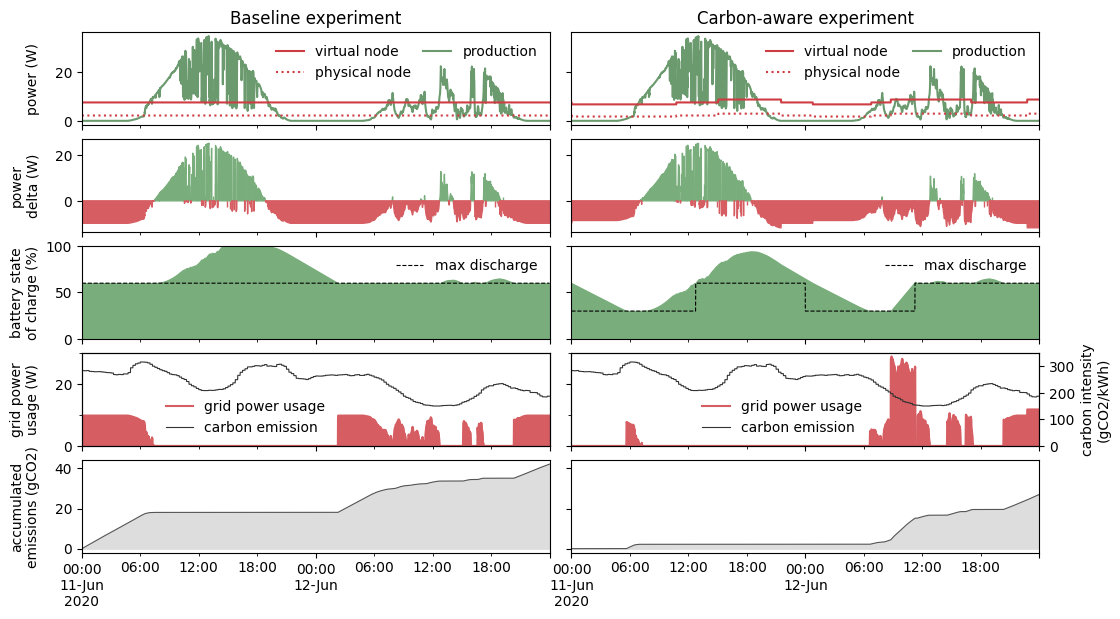

In [4]:
RED = "#D65D62"
GREEN = "#79ae7c"

def plot_evaluation(measurements_df, axs, title: str, left: bool):
    axs[0].set_title(title)

    # Unpack data
    p_prod = measurements_df["p_solar"]
    p_computing_system = - measurements_df["p_computing_system"]
    p_grid = - measurements_df["p_grid"]
    battery_soc = measurements_df["battery_soc"]
    battery_min_soc = measurements_df["battery_min_soc"]
    carbon = measurements_df["carbon_intensity"]
    physical_node = measurements_df["computing_system_info.mpm0"]
    virtual_node = measurements_df["computing_system_info.mpm1"]

    # Plot Production and Consumption
    p_prod.plot(ax=axs[0], color="#6b9a6e", label="production")
    physical_node.plot(ax=axs[0], color="#ce3d43", label="physical node", linestyle=":")
    virtual_node.plot(ax=axs[0], color="#ce3d43", label="virtual node")
    axs[0].set_ylabel("power (W)")
    h, l = axs[0].get_legend_handles_labels()
    axs[0].legend([h[2], h[1], h[0]], [l[2], l[1], l[0]], frameon=False, ncol=2, columnspacing=0.9)

    # Plot Production/Consumption delta
    x = p_prod - p_computing_system
    x.plot(ax=axs[1], alpha=0)
    axs[1].fill_between(x.index, 0, x.values, where=x.values>0, color=GREEN)
    axs[1].fill_between(x.index, 0, x.values, where=x.values<0, color=RED)
    axs[1].set_ylabel("power\ndelta (W)")

    # Plot Battery State of Charge
    battery_soc.plot(ax=axs[2], alpha=0)
    axs[2].fill_between(battery_soc.index, 0, battery_soc.values * 100, color=GREEN)
    axs[2].set_ylim(0, 100)
    axs[2].set_ylabel("battery state\nof charge (%)")
    (battery_min_soc * 100).plot(ax=axs[2], linestyle="--", linewidth=.8, color="black", label="max discharge")
    h, l = axs[2].get_legend_handles_labels()
    axs[2].legend(h[1:], l[1:], frameon=False)

    # Plot grid power and carbon emission
    p_grid[p_grid < 0] = 0
    p_grid.plot(ax=axs[3], color=RED, linestyle="-")
    axs[3].fill_between(p_grid.index, 0, p_grid.values.astype(float), color=RED)
    axs[3].set_ylim(0, 30)
    axs[3].set_yticks([0, 20])
    axs[3].set_ylabel("grid power\nusage (W)")
    ax3_twin = axs[3].twinx()
    carbon.plot(ax=ax3_twin, color="#333", linewidth=.8)
    ax3_twin.set_ylim(0, 350)
    if left:
        ax3_twin.set_yticks([])
        x = 0.35
    else:
        ax3_twin.set_ylabel("carbon intensity\n(gCO2/kWh)")
        ax3_twin.set_yticks([0, 100, 200, 300])
        x = 0.45
    h1, l1 = axs[3].get_legend_handles_labels()
    h2, l2 = ax3_twin.get_legend_handles_labels()
    axs[3].legend(h1 + h2, ["grid power usage", "carbon emission"], frameon=False, loc='upper center', bbox_to_anchor=(x, 0.63))

    # Plot accumulated carbon emission
    emissions = p_grid * carbon  # 60 Ws * gCO2/kWh  //  gCO2/60000 // kgCO2/60000/1000
    emissions /= 60000
    emissions.cumsum().plot(ax=axs[4], color="#555", linewidth=.8)
    axs[4].fill_between(emissions.index, emissions.cumsum().values, color="#ddd")
    axs[4].set_ylabel("accumulated\nemissions (gCO2)")

fig, axs = plt.subplots(ncols=2, nrows=5, sharex="col", sharey="row", figsize=(10,5.5))
fig.tight_layout(pad=0)
plot_evaluation(baseline_experiment, axs[:,0], title="Baseline experiment", left=True)
plot_evaluation(carbon_aware_experiment, axs[:,1], title="Carbon-aware experiment", left=False)
fig.align_ylabels()